In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
import os
from glob import glob
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Input
from tensorflow.keras.models import Model, load_model, save_model ,Sequential
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D,MaxPooling2D, concatenate, Dense, Flatten, UpSampling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K

In [2]:
root_dir='../input/sun-segmented/mask_123'
root_polyps='../input/sun-segmented/mask_123'
root_annotations='../input/sun-polyps/annotation_csv'

In [3]:
less_more_data=pd.read_csv('../input/less-more-5/less_more.csv')
less_more_data.head()

,Less5,More5
0,3,1.0
1,4,2.0
2,5,7.0
3,6,12.0
4,9,23.0


In [4]:
import cv2
import torch
import urllib.request

import matplotlib.pyplot as plt

In [5]:
pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 431.5/431.5 kB 2.1 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [8]:
model_type = "DPT_Large"     # MiDaS v3 - Large     (highest accuracy, slowest inference speed)
#model_type = "DPT_Hybrid"   # MiDaS v3 - Hybrid    (medium accuracy, medium inference speed)
#model_type = "MiDaS_small"  # MiDaS v2.1 - Small   (lowest accuracy, highest inference speed)

midas = torch.hub.load("intel-isl/MiDaS", model_type)

Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master
Downloading: "https://github.com/intel-isl/DPT/releases/download/1_0/dpt_large-midas-2f21e586.pt" to /root/.cache/torch/hub/checkpoints/dpt_large-midas-2f21e586.pt


  0%|          | 0.00/1.28G [00:00<?, ?B/s]

In [9]:
midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")

if model_type == "DPT_Large" or model_type == "DPT_Hybrid":
    transform = midas_transforms.dpt_transform
else:
    transform = midas_transforms.small_transform

Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master


In [10]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
midas.to(device)
midas.eval()

DPTDepthModel(
  (pretrained): Module(
    (model): VisionTransformer(
      (patch_embed): PatchEmbed(
        (proj): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16))
        (norm): Identity()
      )
      (pos_drop): Dropout(p=0.0, inplace=False)
      (blocks): Sequential(
        (0): Block(
          (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
          (attn): Attention(
            (qkv): Linear(in_features=1024, out_features=3072, bias=True)
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=1024, out_features=1024, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
          )
          (drop_path): Identity()
          (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=1024, out_features=4096, bias=True)
            (act): GELU()
            (drop1): Dropout(p=0.0, inplace=False)
            (fc2): Linear(in_features=4

In [11]:
polyp_dir='../input/sun-segmented/mask_123'
cases_less_5=[]
for idx in range(less_more_data.shape[0]):
    case=less_more_data[less_more_data.columns[0]][idx]
    case='case'+str(case)
    case=polyp_dir+'/'+case
    img=cv2.imread(case)
    
    cases_less_5.append(case)

In [12]:
from tqdm import tqdm

In [13]:
images_less_5=[]
for idx,x in tqdm(enumerate(cases_less_5)):
    case=cases_less_5[idx]
    try: 
        items= os.listdir(case)
    
        for index in range(len(items)):
            img=cv2.imread(case+'/'+items[index])
            if img.max()==0:
                continue
            else:
                images_less_5.append(case+'/'+items[index])
    except:
        continue

33it [00:50,  1.54s/it]


In [14]:
images_less_5[:2]

['../input/sun-segmented/mask_123/case3/case_M_20181004093748_0U62372100445348_1_001_001-1_a4_ayy_image0163.png',
 '../input/sun-segmented/mask_123/case3/case_M_20181004093748_0U62372100445348_1_001_001-1_a4_ayy_image0099.png']

In [15]:
cases_more_5=[]
polyp_dir='../input/sun-segmented/mask_123'
for idx in range(less_more_data.shape[0]):
    case=less_more_data[less_more_data.columns[1]][idx]
    try:
        case=int(case)
        case='case'+str(case)
        case=polyp_dir+'/'+case
        cases_more_5.append(case)
    except:
        pass
  

In [16]:
images_more_5=[]
for idx,x in tqdm(enumerate(cases_more_5)):
    case=cases_more_5[idx]
    try: 
        items= os.listdir(case)
    
        for index in range(len(items)):
            img=cv2.imread(case+'/'+items[index])
            if img.max()==0:
                continue
            else:
                images_more_5.append(case+'/'+items[index])
    except:
        continue

32it [01:55,  3.62s/it]


In [17]:
len( images_more_5),len(images_less_5)

(17398, 5967)

In [18]:
from sklearn.model_selection import train_test_split
_,images_more=train_test_split(images_more_5,random_state=42,test_size=0.4)

In [19]:
len(images_more)

6960

In [20]:
#Assembling into a dataframe
Polyp_Data_More=pd.DataFrame(
    {
        "images":images_more,
        "label":1
    }
)

In [21]:
Polyp_Data_Less=pd.DataFrame(
    {
        "images":images_less_5,
        "label":0
    }
)
Polyp_Data_Less.head()

,images,label
0,../input/sun-segmented/mask_123/case3/case_M_2...,0
1,../input/sun-segmented/mask_123/case3/case_M_2...,0
2,../input/sun-segmented/mask_123/case3/case_M_2...,0
3,../input/sun-segmented/mask_123/case3/case_M_2...,0
4,../input/sun-segmented/mask_123/case3/case_M_2...,0


In [22]:
Polyp_Data=pd.concat([Polyp_Data_Less,Polyp_Data_More],ignore_index=True)

In [23]:
from sklearn.model_selection import train_test_split
Polyp_Train,Polyp_Test=train_test_split(Polyp_Data,test_size=0.3,random_state=42,)


In [24]:
Polyp_Valid,Polyp_Test=train_test_split(Polyp_Test,test_size=0.5,random_state=42)

In [26]:
Polyp_Train = Polyp_Train.reset_index()

In [27]:
Polyp_Valid=Polyp_Valid.reset_index()
Polyp_Valid.head()

,index,images,label
0,3615,../input/sun-segmented/mask_123/case48/case_M_...,0
1,7371,../input/sun-segmented/mask_123/case24/case_M_...,1
2,3448,../input/sun-segmented/mask_123/case34/case_M_...,0
3,7237,../input/sun-segmented/mask_123/case32/case_M_...,1
4,5666,../input/sun-segmented/mask_123/case88/case_M_...,0


In [28]:
Polyp_Test=Polyp_Test.reset_index()
Polyp_Test.head()

,index,images,label
0,5872,../input/sun-segmented/mask_123/case100/case_M...,0
1,9322,../input/sun-segmented/mask_123/case61/case_M_...,1
2,9584,../input/sun-segmented/mask_123/case50/case_M_...,1
3,511,../input/sun-segmented/mask_123/case10/case_M_...,0
4,12229,../input/sun-segmented/mask_123/case37/case_M_...,1


In [29]:
from collections import defaultdict
import copy
import random
import os
import shutil
from urllib.request import urlretrieve
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.optim
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
cudnn.benchmark = True

In [30]:
class PolypDataset(Dataset):
    def __init__(self,images_dataframe,transform=None):
        self.image_paths=images_dataframe
        self.transform=transform
    def __len__(self):
        return self.image_paths.shape[0]
    def __getitem__(self,idx):
        image_filepath=(self.image_paths['images'][idx])
        #print(self.image_paths['images'][idx])
        #print(image_filepath)
        mask_image=cv2.imread(image_filepath,cv2.IMREAD_GRAYSCALE)
        req_img_1=image_filepath.split('/')[4]
        req_img_2=image_filepath.split('/')[5]
        req_img='/'+req_img_1+'/'+req_img_2
        req_img='../input/sun-polyps/Polyps/Polyps'+req_img
        req_img='..'+req_img.split('.')[2]+'.jpg'
        #print(req_img)
        img=cv2.imread(req_img)
        image=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        resized_image=cv2.resize(image,(224,224))
        input_batch = transform(resized_image).to(device)
        with torch.no_grad():
            prediction = midas(input_batch)

            prediction = torch.nn.functional.interpolate(
            prediction.unsqueeze(1),
            size=img.shape[:2],
            mode="bicubic",
            align_corners=False,
           ).squeeze()
  
        output = prediction.cpu().numpy()
        
        '''for row in range(mask_image.shape[0]):
            for col in range(mask_image.shape[1]):
                mask_image[row][col]=output[row][col]
        '''
       
        for row in range(mask_image.shape[0]):
            for col in range(mask_image.shape[1]):
                if mask_image[row][col]==255:
                    mask_image[row][col]=output[row][col]
                   
        
        label=self.image_paths['label'][idx]
        mask=mask_image
        mask=mask/255.
        if self.transform is not None:
            mask=self.transform(image=mask)["image"]
        return mask,label

In [31]:
train_transform = A.Compose(
    [
        ToTensorV2(),
    ]
)
train_dataset = PolypDataset(images_dataframe=Polyp_Train, transform=train_transform)
val_transform = A.Compose(
    [
        ToTensorV2(),
    ]
)
val_dataset = PolypDataset(images_dataframe=Polyp_Valid, transform=val_transform)
test_transform = A.Compose(
    [
        ToTensorV2(),
    ]
)
test_dataset = PolypDataset(images_dataframe=Polyp_Test, transform=test_transform)

In [32]:
class MetricMonitor:
    def __init__(self, float_precision=3):
        self.float_precision = float_precision
        self.reset()

    def reset(self):
        self.metrics = defaultdict(lambda: {"val": 0, "count": 0, "avg": 0})

    def update(self, metric_name, val):
        metric = self.metrics[metric_name]

        metric["val"] += val
        metric["count"] += 1
        metric["avg"] = metric["val"] / metric["count"]

    def __str__(self):
        return " | ".join(
            [
                "{metric_name}: {avg:.{float_precision}f}".format(
                    metric_name=metric_name, avg=metric["avg"], float_precision=self.float_precision
                )
                for (metric_name, metric) in self.metrics.items()
            ]
        )

# Model Architecture

In [33]:
import torch.nn as nn
class BinaryNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1=nn.Conv2d(1,16,kernel_size=3,padding=1,stride=1)
        self.relu=nn.ReLU(inplace=True)
        self.maxpool1=nn.MaxPool2d(kernel_size=2,stride=2)
        self.batch1=nn.BatchNorm2d(16)
        self.conv2=nn.Conv2d(16,32,kernel_size=3,padding=1,stride=1)
        self.maxpool2=nn.MaxPool2d(kernel_size=2,stride=2)
        self.batch2=nn.BatchNorm2d(32)
        self.linear1=nn.Linear(56*56*32,64)
        self.linear2=nn.Linear(64,1)

    def forward(self,x):
        out=self.conv1(x)
        out=self.batch1(out)
        out=self.relu(out)
        out=self.maxpool1(out)
        out=self.conv2(out)
        out=self.batch2(out)
        out=self.relu(out)
        out=self.maxpool2(out)
        out=out.view(-1,56*56*32)
        out=self.linear1(out)
        out=self.relu(out)
        out=self.linear2(out)
        
        return out

In [34]:
net=BinaryNet()

In [35]:
params = {
    "device": "cuda",
    "lr": 0.001,
    "batch_size": 32,
    "num_workers": 4,
    "epochs": 60,
}

In [36]:
model = net
model = model.to(params["device"])
criterion = nn.BCEWithLogitsLoss().to(params["device"])
optimizer = torch.optim.Adam(model.parameters(), lr=params["lr"])

In [37]:
train_loader = DataLoader(
    train_dataset, batch_size=params["batch_size"], shuffle=True, pin_memory=True,
)
val_loader = DataLoader(
    val_dataset, batch_size=params["batch_size"], shuffle=False, pin_memory=True,
)

In [38]:
test_loader = DataLoader(
    test_dataset, batch_size=params["batch_size"], shuffle=False, pin_memory=True,
)

In [39]:
def train(train_loader, model, criterion, optimizer, epoch, params):
    metric_monitor = MetricMonitor()
    model.train()
    stream = tqdm(train_loader)
    for i, (images, target) in enumerate(stream, start=1):
        images = images.to(params["device"], non_blocking=True)
        images=images.float()
        target = target.to(params["device"], non_blocking=True).float().view(-1, 1)
        output = model(images)
        loss = criterion(output, target)
        accuracy = calculate_accuracy(output, target)
        metric_monitor.update("Loss", loss.item())
        metric_monitor.update("Accuracy", accuracy)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        stream.set_description(
            "Epoch: {epoch}. Train.      {metric_monitor}".format(epoch=epoch, metric_monitor=metric_monitor)
        )

In [40]:
def validate(val_loader, model, criterion, epoch, params):
    metric_monitor = MetricMonitor()
    model.eval()
    stream = tqdm(val_loader)
    with torch.no_grad():
        for i, (images, target) in enumerate(stream, start=1):
            images = images.to(params["device"], non_blocking=True)
            images=images.float()
            target = target.to(params["device"], non_blocking=True).float().view(-1, 1)
            output = model(images)
            loss = criterion(output, target)
            accuracy = calculate_accuracy(output, target)

            metric_monitor.update("Loss", loss.item())
            metric_monitor.update("Accuracy", accuracy)
            stream.set_description(
                "Epoch: {epoch}. Validation. {metric_monitor}".format(epoch=epoch, metric_monitor=metric_monitor)
            )

In [41]:
def calculate_accuracy(output, target):
    output = torch.sigmoid(output) >= 0.5
    target = target == 1.0
    return torch.true_divide((target == output).sum(dim=0), output.size(0)).item()

In [42]:
for epoch in range(1, params["epochs"] + 1):
    train(train_loader, model, criterion, optimizer, epoch, params)
    validate(val_loader, model, criterion, epoch, params)

Epoch: 1. Train.      Loss: 0.691 | Accuracy: 0.735: 100%|██████████| 283/283 [40:16<00:00,  8.54s/it]
Epoch: 1. Validation. Loss: 0.509 | Accuracy: 0.752: 100%|██████████| 61/61 [08:37<00:00,  8.49s/it]
Epoch: 2. Train.      Loss: 0.420 | Accuracy: 0.805: 100%|██████████| 283/283 [39:02<00:00,  8.28s/it]
Epoch: 2. Validation. Loss: 0.461 | Accuracy: 0.785: 100%|██████████| 61/61 [08:17<00:00,  8.16s/it]
Epoch: 3. Train.      Loss: 0.343 | Accuracy: 0.850: 100%|██████████| 283/283 [38:54<00:00,  8.25s/it]
Epoch: 3. Validation. Loss: 1.053 | Accuracy: 0.577: 100%|██████████| 61/61 [08:23<00:00,  8.25s/it]
Epoch: 4. Train.      Loss: 0.284 | Accuracy: 0.876: 100%|██████████| 283/283 [39:01<00:00,  8.27s/it]
Epoch: 4. Validation. Loss: 0.572 | Accuracy: 0.750: 100%|██████████| 61/61 [08:20<00:00,  8.21s/it]
Epoch: 5. Train.      Loss: 0.244 | Accuracy: 0.896: 100%|██████████| 283/283 [38:59<00:00,  8.27s/it]
Epoch: 5. Validation. Loss: 0.515 | Accuracy: 0.790: 100%|██████████| 61/61 [08:2

KeyboardInterrupt: 

In [44]:
pt='./model_simple.pt'
torch.save(model,pt)

In [128]:
#Saving model with state_dict:
path='./model_simple_state_dict.pt'
torch.save(model.state_dict(),path)

In [45]:
#Running on test dataset
validate(test_loader, model, criterion,1, params)

Epoch: 1. Validation. Loss: 1.022 | Accuracy: 0.783: 100%|██████████| 61/61 [08:48<00:00,  8.66s/it]


In [57]:
img=torch.tensor([[16],[1]])

In [69]:
img=torch.squeeze(img)
img.shape

torch.Size([2])

In [72]:
model.eval()
preds=[]
targets=[]
with torch.no_grad():
    for data,target in test_loader:
        data,target=data.to(device),target.to(device)
        data=data.float()
        targets.append(target)
        output=model(data)
        pred=torch.squeeze(output)
        preds.append(pred)
        

In [84]:
#Sigmoid layer and threshold have been applied to predict

In [85]:
new_preds=[]

for item in range(len(preds)):
    for idx in range(len(preds[item])):
        new_preds.append(preds[item][idx])

In [89]:
new_targets=[]

for item in range(len(targets)):
    for idx in range(len(targets[item])):
        new_targets.append(targets[item][idx])

In [94]:
for idx in range(len(new_targets)):
    new_targets[idx]=new_targets[idx].cpu()
    new_preds[idx]=new_preds[idx].cpu()

In [102]:
new_targets=np.array(new_targets)
new_preds=np.array(new_preds)
for idx in range(new_targets.shape[0]):
    new_targets[idx]=int(new_targets[idx])
    new_preds[idx]=int(new_preds[idx])

In [120]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
cm=confusion_matrix(new_targets,new_preds)

In [121]:
cm

array([[633, 282],
       [148, 877]])

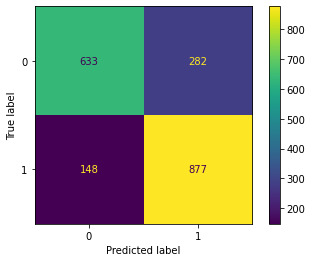

In [126]:

disp=ConfusionMatrixDisplay(cm)

disp.plot()
plt.show()

# As we can see, our model makes a total of (633+877) predictions correctly. Thus accuracy is 77.83%.
# Recall is : 75.66%
# Precision is: 85.56%
# F1-Score is : 0.8027
# 

In [ ]:
#Showing some predictions:
